In [1]:
from modules.create_plots import generate_plots
from modules.irisRecognition import irisRecognition
from torchvision.transforms import v2 as transforms
from torchvision.io import decode_image, ImageReadMode
from tqdm.notebook import tqdm
import itertools
import os
import numpy as np
import pandas as pd
import shutil
import torch

In [2]:
BATCH_SIZE = 128
scores_csv = "scores.csv"

In [3]:
def save_embeddings(irisRec: irisRecognition, embeddings_dir: str):
    enroll_files = [os.path.join("data/enroll_im_polar", f) for f in os.listdir("data/enroll_im_polar")]
    search_files = [os.path.join("data/search_im_polar", f) for f in os.listdir("data/search_im_polar")]

    d = {
        "enroll": enroll_files,
        "search": search_files,
    }

    for t, image_files in d.items():
        for i in range(0, len(image_files), BATCH_SIZE):
            batch_images = image_files[i:i+BATCH_SIZE]
            image_tensors = load_image_tensors(batch_images, irisRec.device)
            embeddings = irisRec.extractVectors(image_tensors)

            for img_path, embedding in zip(batch_images, embeddings):
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                embedding_path = os.path.join(embeddings_dir, f"{t}_{base_name}.pt")
                torch.save(embedding, embedding_path)

def ppm_to_embedding(filename: str):
    return os.path.join("embeddings", filename.replace('/', '_').replace('.ppm', '.pt'))

def load_image_tensors(filenames, device):
    transform = transforms.Compose((
        transforms.ToDtype(torch.float, scale=True),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.Grayscale(3),
    ))
    images = [transform(decode_image(filename, mode=ImageReadMode.GRAY)) for filename in filenames]
    images_tensor = torch.stack(images).to(device=device)
    return images_tensor

In [4]:
device = torch.device("mps")
os.makedirs("embeddings", exist_ok=True)
for model in os.listdir("models"):
    model_name = os.path.splitext(model)[0]
    df = pd.read_csv(scores_csv)
    if not model.endswith(".pt") or f"{model_name}_score" in df.columns:
        continue
    print(model)
    irisRec = irisRecognition(model, dropout=0.0, fp16=True, num_features=512)

    shutil.rmtree("embeddings", ignore_errors=True)
    os.makedirs("embeddings")
    save_embeddings(irisRec, "embeddings")

    df[f"{model_name}_score"] = np.nan

    for pairs in tqdm(itertools.batched(df[["Enroll", "Search"]].itertuples(index=True, name=None), BATCH_SIZE)):
        filenames = itertools.chain(*(map(ppm_to_embedding, pair[1:]) for pair in pairs))
        embeddings = torch.stack([torch.load(fn) for fn in filenames]).to(device)
        scores = irisRec.matchVectorsArc(embeddings[0::2], embeddings[1::2])
        df.loc[[pair[0] for pair in pairs], f"{model_name}_score"] = scores.cpu().numpy()
        df.to_csv(scores_csv, index=False)

Loading scores: 100%|██████████| 83680/83680 [00:02<00:00, 41770.12it/s]


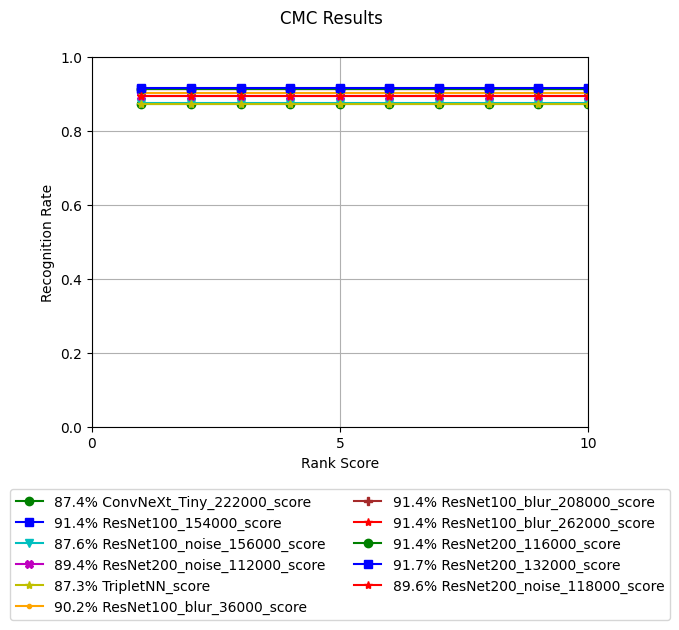

In [5]:
# Generate ROC and CMC plots
generate_plots(scores_csv=scores_csv, cmc_rank=10)